# Cart Pole Balancing

In [1]:
import numpy as np
import gym
import random
import time
import math
from collections import defaultdict
import matplotlib.pyplot as plt


# Define the QLearningAgent class
class QLearningAgent:
    
    # Initialisation
    def __init__(self, action_space, state_space, alpha, epsilon, gamma, decay_rate, min_epsilon):
        # State action space
        self.action_space = action_space
        self.state_space = state_space
        # Parameters
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.decay_rate = decay_rate
        self.min_epsilon = min_epsilon
        # Lists and dictionaries
        self.q_table = defaultdict(lambda: np.zeros(self.action_space)) # Dictionary with only 0s
        self.all_losses = [] # Empty list
        self.win_rates = []
        self.win_counts = []
        self.all_rewards = []
        self.optimal_policy = {}
    
  
    def select_action(self, state):
        """
        Select action based on epsilon-greedy exploration
        :param state: Current state
        :return state: Action to take
        """
        if random.uniform(0, 1) < self.epsilon:
            return random.choice(range(self.action_space)) # Exploration
        else:
            return np.argmax(self.q_table[state]) # Exploitation
    
    
    def update_q_value(self, state, action, reward, next_state):
        """
        Update the Q-table with maximal Q-value.
        :param state: Current state
        :param action: Action take
        :param reward: Reward received
        :param next_state: Next state reached
        
        """
        best_next_action = np.argmax(self.q_table[next_state])
        TD_target = reward + self.gamma * self.q_table[next_state][best_next_action]
        TD_error = TD_target - self.q_table[state][action]
        self.q_table[state][action] += self.alpha * TD_error
        
        # Calculate the loss
        loss = TD_error**2
        self.all_losses.append(loss)

 
    def decay_epsilon(self):
        """ Decay exploration rate """
        if self.epsilon > self.min_epsilon:
            self.epsilon *= self.decay_rate
        else:
            self.epsilon = self.min_epsilon
            
    def reset(self):
        """ Reset Q-table. Useful for episodic games """
        self.q_table = defaultdict(lambda: np.zeros(self.action_space))

        
    def get_q_table(self):
        """ Get Q-table """
        return dict(self.q_table)

In [2]:
# Initialise the environment
env = gym.make("CartPole-v1")
#print(env.action_space.n)

# Hyperparameters
alpha = 0.1
gamma = 0.95
epsilon = 1.0
min_epsilon = 0.05
episodes = 100000  # Reduced number of episodes for testing
total = 0
total_reward = 0
prior_reward = 0

# Observation space discretisation
np_array_win_size = np.array([0.25, 0.25, 0.01, 0.1])

# Decay rate for epsilon
decay_rate = 0.99995

# Observation space size for discretisation
observation_space_size = [30, 30, 50, 50]

# Initialise Q-learning agent
agent = QLearningAgent(action_space=env.action_space.n,
                       state_space=observation_space_size,
                       alpha=alpha,
                       epsilon=epsilon,
                       gamma=gamma,
                       decay_rate=decay_rate,
                       min_epsilon=min_epsilon)

# Function to convert continuous state to discrete state
def get_discrete_state(state):
    discrete_state = state / np_array_win_size + np.array([15, 10, 1, 10])
    return tuple(discrete_state.astype(int))

# Main loop for training the agent
for episode in range(episodes + 1):
    t0 = time.time()
    initial_state, _ = env.reset()
    state = initial_state
    discrete_state = get_discrete_state(state)
    done = False
    episode_reward = 0

    if episode % 2000 == 0: 
        print(f"Episode: {episode}")

    while not done: 
        action = agent.select_action(discrete_state)
        new_state, reward, done, truncated, _ = env.step(action)
        episode_reward += reward
        new_discrete_state = get_discrete_state(new_state)

        if episode % 2000 == 0:
            env.render()

        if not done and not truncated:
            agent.update_q_value(discrete_state, action, reward, new_discrete_state)

        discrete_state = new_discrete_state

    agent.decay_epsilon()
    agent.all_rewards.append(episode_reward)

    t1 = time.time()
    episode_total = t1 - t0
    total += episode_total

    total_reward += episode_reward
    prior_reward = episode_reward

    if episode % 1000 == 0:
        mean = total / 1000
        print(f"Time Average: {mean}")
        total = 0

        mean_reward = total_reward / 1000
        print(f"Mean Reward: {mean_reward}")
        total_reward = 0

env.close()

Episode: 0
Time Average: 4.526138305664063e-06
Mean Reward: 0.043


/Users/LaetitiaRomestan/opt/anaconda3/lib/python3.9/site-packages/gym/envs/classic_control/cartpole.py:211: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym("CartPole-v1", render_mode="rgb_array")
  gym.logger.warn(


Time Average: 0.0003914346694946289
Mean Reward: 22.693
Episode: 2000
Time Average: 0.0003726673126220703
Mean Reward: 22.628
Time Average: 0.000419851541519165
Mean Reward: 24.035
Episode: 4000
Time Average: 0.00040453529357910154
Mean Reward: 24.172
Time Average: 0.0004423949718475342
Mean Reward: 26.082
Episode: 6000
Time Average: 0.00046300768852233884
Mean Reward: 27.274
Time Average: 0.0005403420925140381
Mean Reward: 28.685
Episode: 8000
Time Average: 0.0005277099609375
Mean Reward: 30.814
Time Average: 0.0007388403415679931
Mean Reward: 33.219
Episode: 10000
Time Average: 0.0007498273849487304
Mean Reward: 35.692
Time Average: 0.000717402458190918
Mean Reward: 40.133
Episode: 12000
Time Average: 0.0007485387325286866
Mean Reward: 42.606
Time Average: 0.0008200216293334961
Mean Reward: 46.448
Episode: 14000
Time Average: 0.0008761816024780274
Mean Reward: 50.605
Time Average: 0.0009777286052703857
Mean Reward: 55.674
Episode: 16000
Time Average: 0.001137373685836792
Mean Reward:

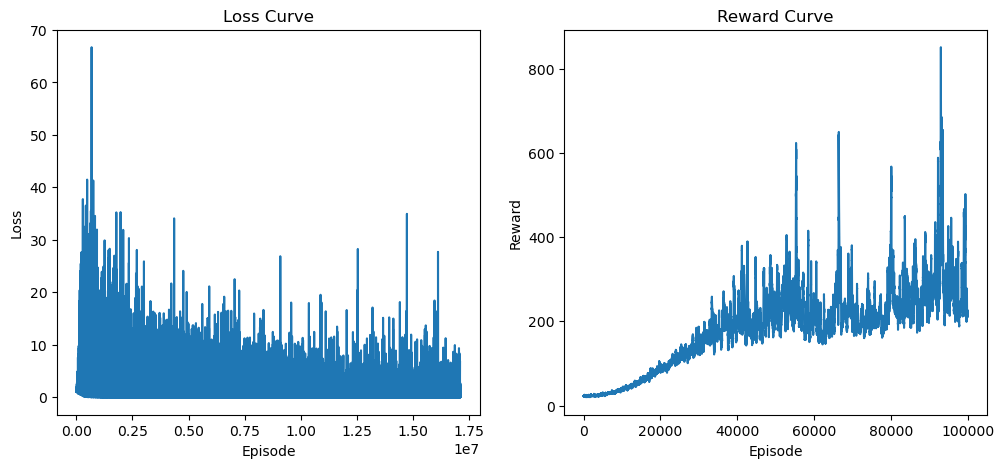

In [3]:

# Function to calculate the moving average
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Calculate the moving average with a window size of 100
smoothed_losses = moving_average(agent.all_losses, 100)
smoothed_rewards = moving_average(agent.all_rewards, 100)

# Plotting the loss and reward curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(smoothed_losses)
plt.title("Loss Curve")
plt.xlabel("Episode")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(smoothed_rewards)
plt.title("Reward Curve")
plt.xlabel("Episode")
plt.ylabel("Reward")

plt.show()